<a href="https://colab.research.google.com/github/Swarno-Coder/nonsense-code/blob/master/Foot_Ulcer_Detection_using_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/uwm-bigdata/wound-segmentation.git

fatal: destination path 'wound-segmentation' already exists and is not an empty directory.


In [ ]:
!nvidia-smi

Fri Apr 19 04:52:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from glob import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from tqdm import tqdm
from PIL import Image
import cv2
import matplotlib.pyplot as plt


In [ ]:
image_paths = sorted(glob("/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/images/*.png"))
mask_paths = sorted(glob("/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/labels/*.png"))

val_img_paths = sorted(glob("/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/validation/images/*.png"))
val_mask_paths = sorted(glob("/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/validation/labels/*.png"))

test_paths = sorted(glob("/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/test/images/*.png"))

In [ ]:
# UNET and it's parts
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)


class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
       x1 = self.up(x1)
       x = torch.cat([x1, x2], 1)
       return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet,self).__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
       down_1, p1 = self.down_convolution_1(x)
       down_2, p2 = self.down_convolution_2(p1)
       down_3, p3 = self.down_convolution_3(p2)
       down_4, p4 = self.down_convolution_4(p3)

       b = self.bottle_neck(p4)

       up_1 = self.up_convolution_1(b, down_4)
       up_2 = self.up_convolution_2(up_1, down_3)
       up_3 = self.up_convolution_3(up_2, down_2)
       up_4 = self.up_convolution_4(up_3, down_1)

       out = self.out(up_4)
       return torch.sigmoid(out)

In [ ]:
# Define dataset class
class CustomDataset(Dataset):
    def __init__(self, image_paths, target_paths, transform=None):
        self.image_paths = image_paths
        self.target_paths = target_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.target_paths:
            target = Image.open(self.target_paths[idx]).convert('L')

        if self.transform:
            image = self.transform(image)
            if self.target_paths:
                target = self.transform(target)
                return image, target
        return image, image_paths[idx]

# Define training parameters
batch_size = 8
learning_rate = 0.002
num_epochs = 40

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load dataset
train_dataset = CustomDataset(
    image_paths=image_paths,
    target_paths=mask_paths,
    transform=transform
)

val_dataset = CustomDataset(
    image_paths=val_img_paths,
    target_paths=val_mask_paths,
    transform=transform)

test_dataset = CustomDataset(
    image_paths=test_paths,
    target_paths=None,
    transform=transform)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for i, m in train_loader: break
i.shape, m

(torch.Size([8, 3, 256, 256]),
 tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  

In [ ]:
def dice_loss(predicted, target, epsilon=1e-6):
    """Compute Dice loss for binary segmentation."""

    # Flatten predictions and targets
    predicted = predicted.view(-1)
    target = target.view(-1)

    # Compute intersection and union
    intersection = (predicted * target).sum()
    union = predicted.sum() + target.sum()

    # Compute Dice coefficient
    dice_coefficient = (2. * intersection + epsilon) / (union + epsilon)

    # Compute Dice loss
    dice_loss = 1 - dice_coefficient

    return dice_loss

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data)

In [14]:
model = UNet(3,1)
model_path = "final_model.pth"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1/40], Loss: 0.0811


  2%|▎         | 1/40 [00:51<33:47, 51.99s/it]

Epoch [1/40], Validation Loss: 0.5761
Epoch [2/40], Loss: 0.0593


  5%|▌         | 2/40 [01:45<33:34, 53.01s/it]

Epoch [2/40], Validation Loss: 0.5512
Epoch [3/40], Loss: 0.0529


  8%|▊         | 3/40 [02:38<32:42, 53.05s/it]

Epoch [3/40], Validation Loss: 0.6767
Epoch [4/40], Loss: 0.0541


 10%|█         | 4/40 [03:32<31:51, 53.11s/it]

Epoch [4/40], Validation Loss: 0.4425
Epoch [5/40], Loss: 0.0519


 12%|█▎        | 5/40 [04:25<31:07, 53.37s/it]

Epoch [5/40], Validation Loss: 0.6176
Epoch [6/40], Loss: 0.0487


 15%|█▌        | 6/40 [05:19<30:12, 53.31s/it]

Epoch [6/40], Validation Loss: 0.5048
Epoch [7/40], Loss: 0.0472


 18%|█▊        | 7/40 [06:12<29:20, 53.34s/it]

Epoch [7/40], Validation Loss: 0.5092
Epoch [8/40], Loss: 0.0427


 20%|██        | 8/40 [07:05<28:26, 53.33s/it]

Epoch [8/40], Validation Loss: 0.6505
Epoch [9/40], Loss: 0.0403


 22%|██▎       | 9/40 [07:59<27:33, 53.34s/it]

Epoch [9/40], Validation Loss: 0.3699
Epoch [10/40], Loss: 0.0390
Epoch [10/40], Validation Loss: 0.3441
Epoch [10/40], Loss: 0.2860


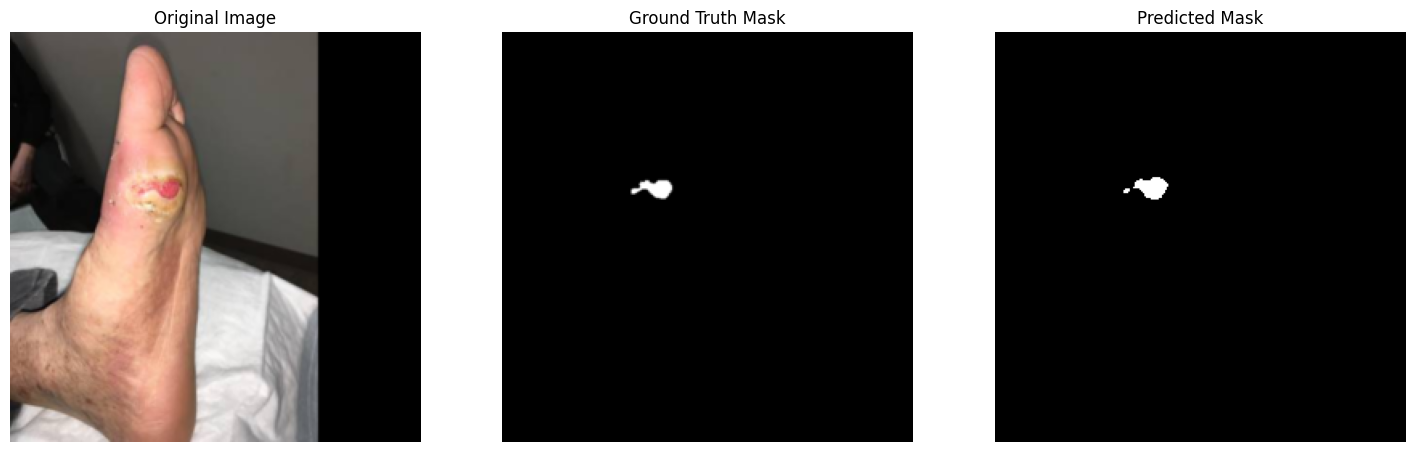

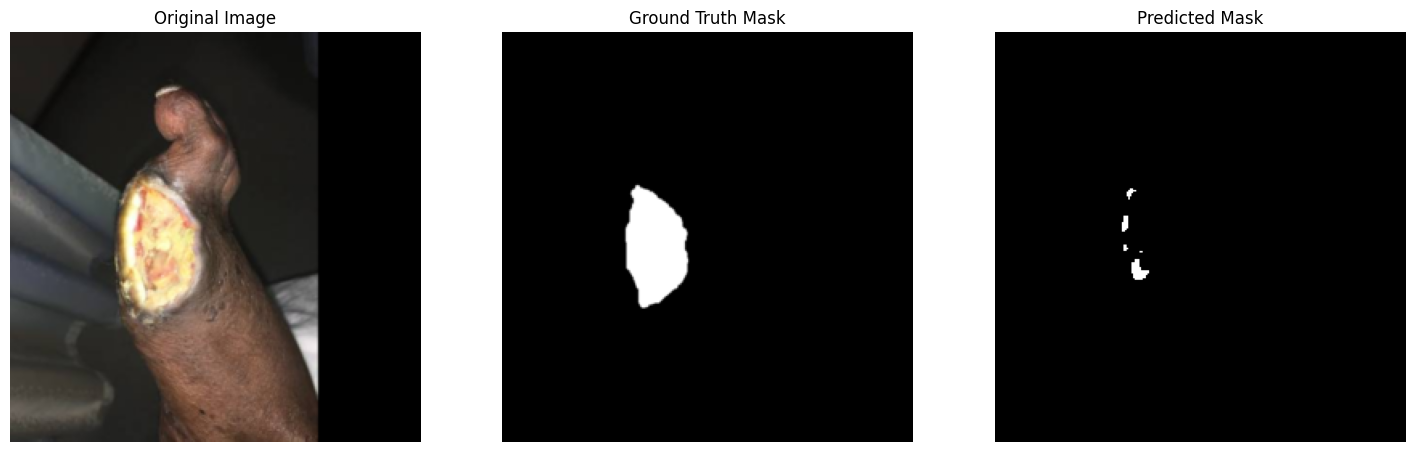

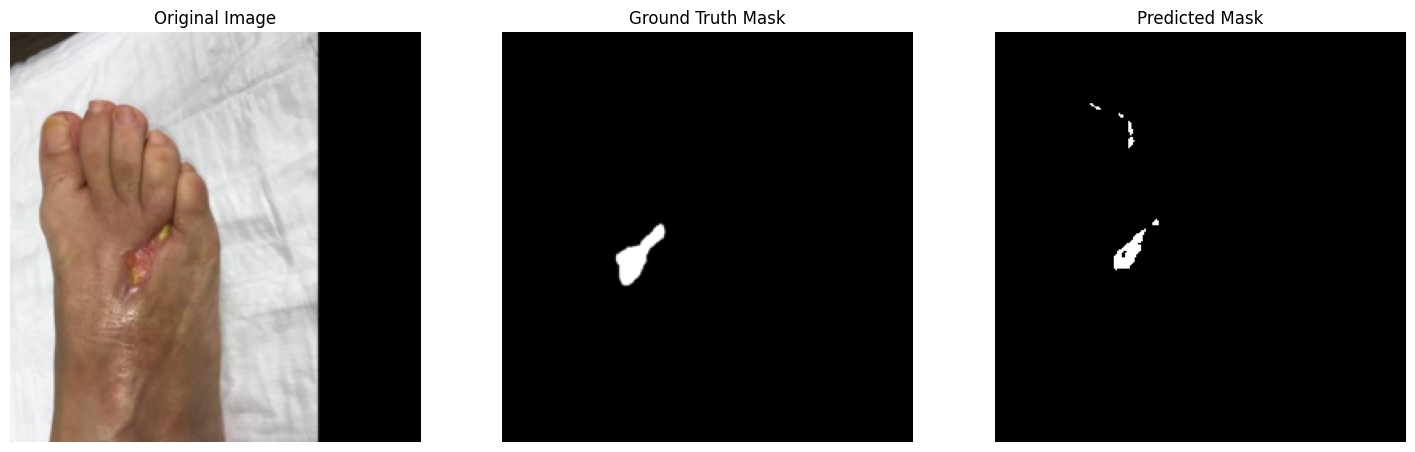

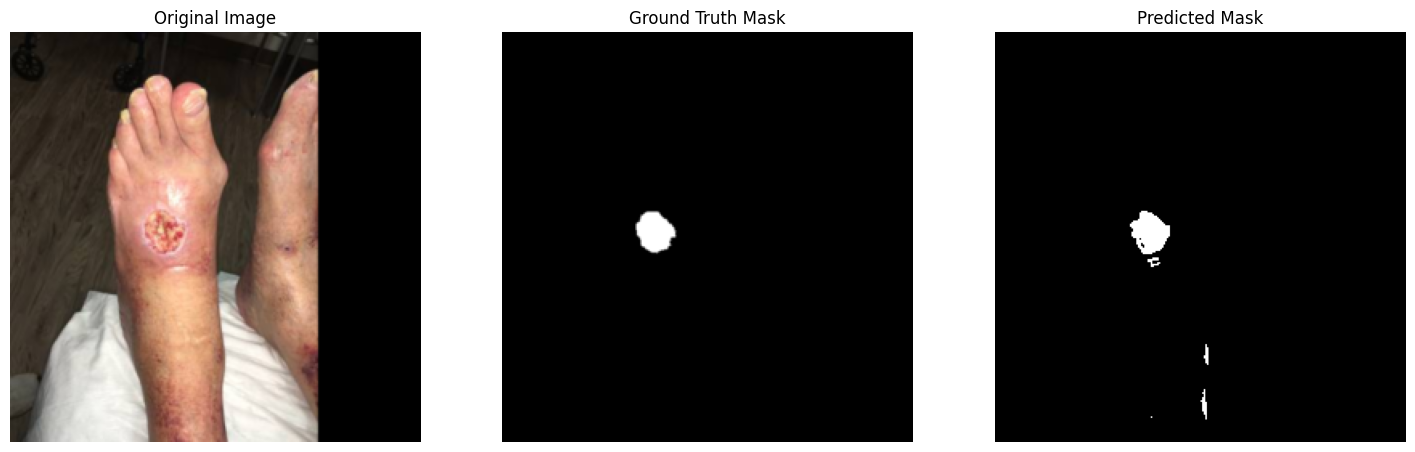

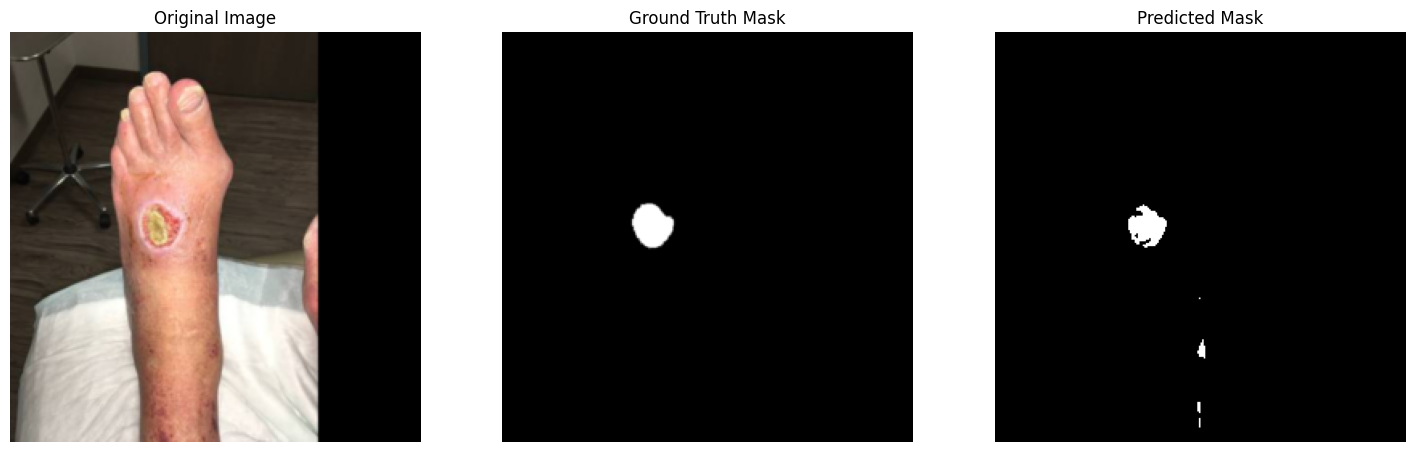

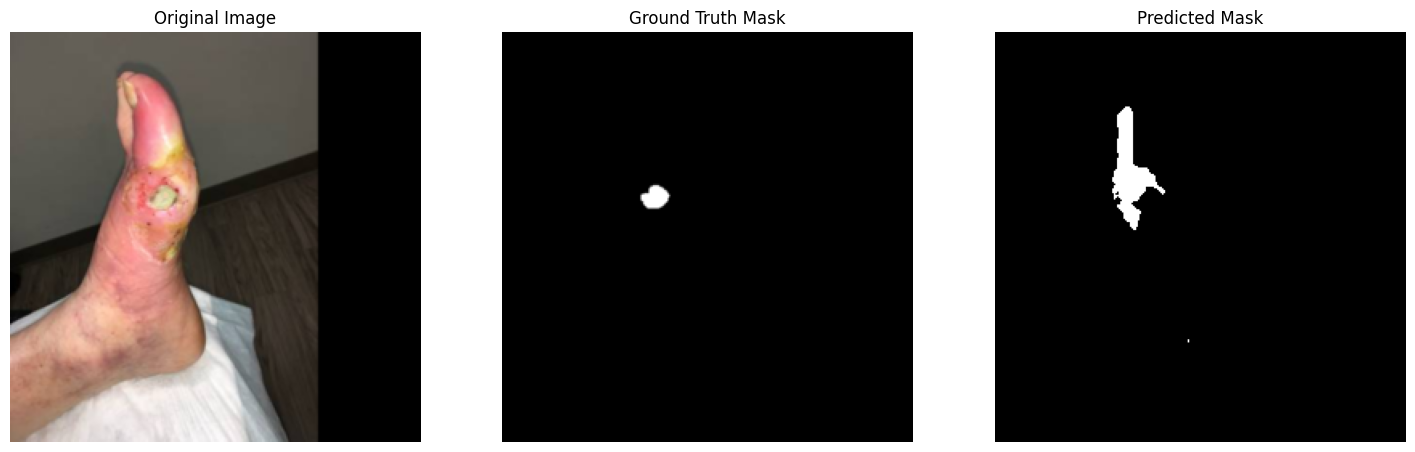

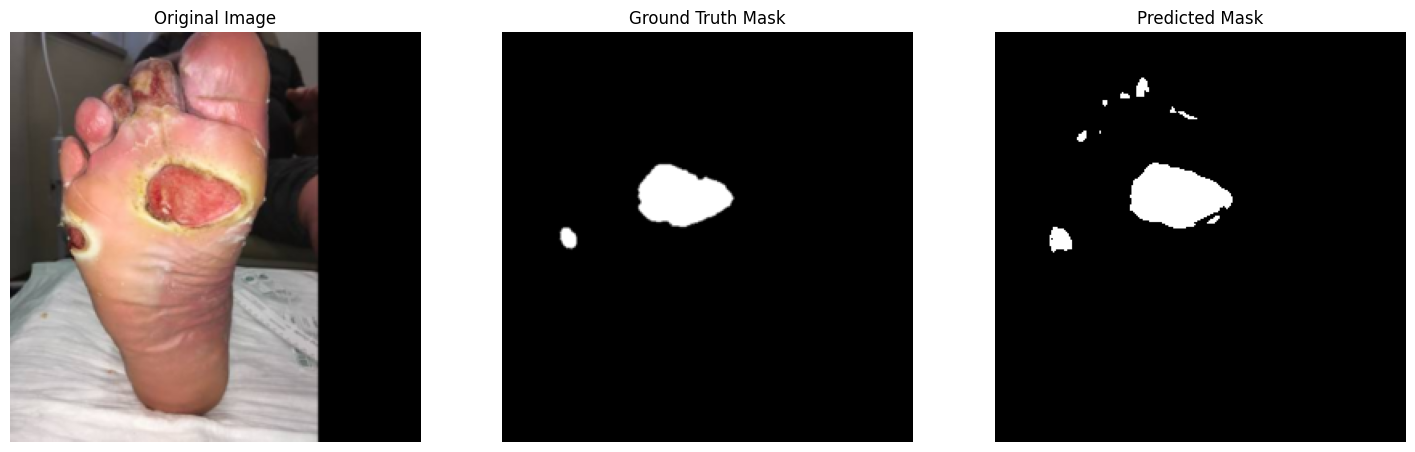

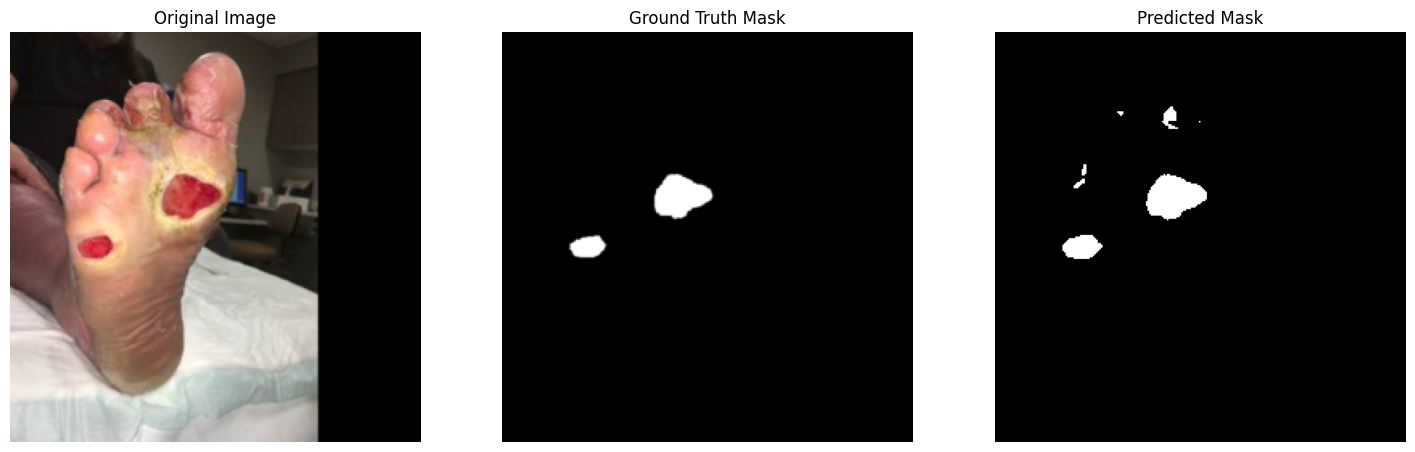

 25%|██▌       | 10/40 [08:55<27:11, 54.38s/it]

Epoch [11/40], Loss: 0.0396


 28%|██▊       | 11/40 [09:49<26:09, 54.11s/it]

Epoch [11/40], Validation Loss: 0.4646
Epoch [12/40], Loss: 0.0399


 30%|███       | 12/40 [10:42<25:06, 53.81s/it]

Epoch [12/40], Validation Loss: 0.3321
Epoch [13/40], Loss: 0.0372


 32%|███▎      | 13/40 [11:35<24:10, 53.73s/it]

Epoch [13/40], Validation Loss: 0.3297
Epoch [14/40], Loss: 0.0332


 35%|███▌      | 14/40 [12:29<23:13, 53.60s/it]

Epoch [14/40], Validation Loss: 0.4832
Epoch [15/40], Loss: 0.0348


 38%|███▊      | 15/40 [13:22<22:18, 53.55s/it]

Epoch [15/40], Validation Loss: 0.3915
Epoch [16/40], Loss: 0.0312


 40%|████      | 16/40 [14:16<21:23, 53.50s/it]

Epoch [16/40], Validation Loss: 0.3571
Epoch [17/40], Loss: 0.0310


 42%|████▎     | 17/40 [15:09<20:27, 53.38s/it]

Epoch [17/40], Validation Loss: 0.2797
Epoch [18/40], Loss: 0.0264


 45%|████▌     | 18/40 [16:02<19:35, 53.43s/it]

Epoch [18/40], Validation Loss: 0.2766
Epoch [19/40], Loss: 0.0272


 48%|████▊     | 19/40 [16:55<18:40, 53.34s/it]

Epoch [19/40], Validation Loss: 0.3014
Epoch [20/40], Loss: 0.0266
Epoch [20/40], Validation Loss: 0.2212
Epoch [20/40], Loss: 0.1873


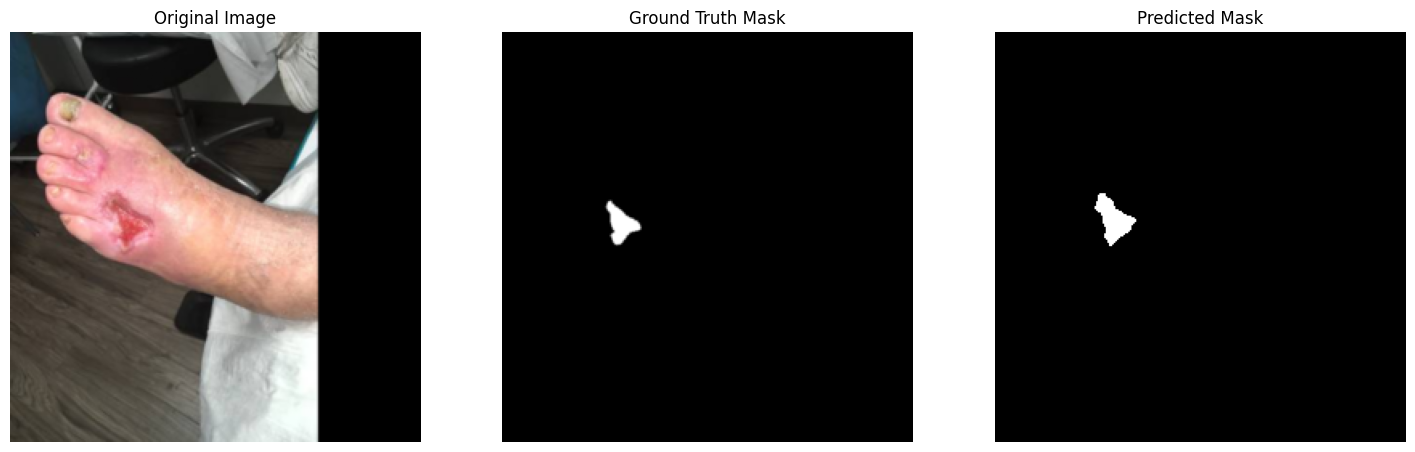

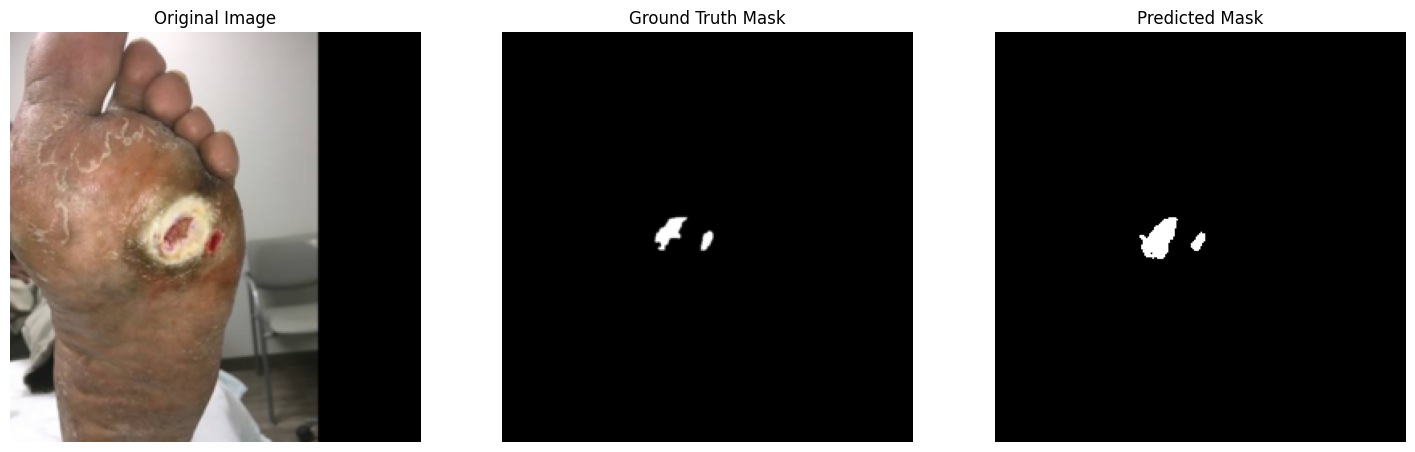

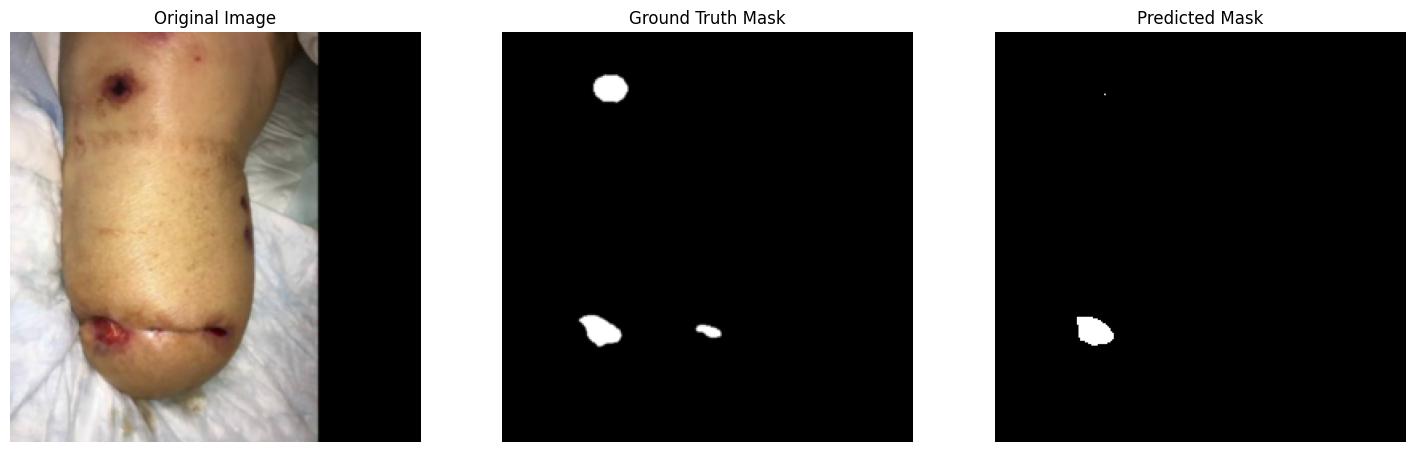

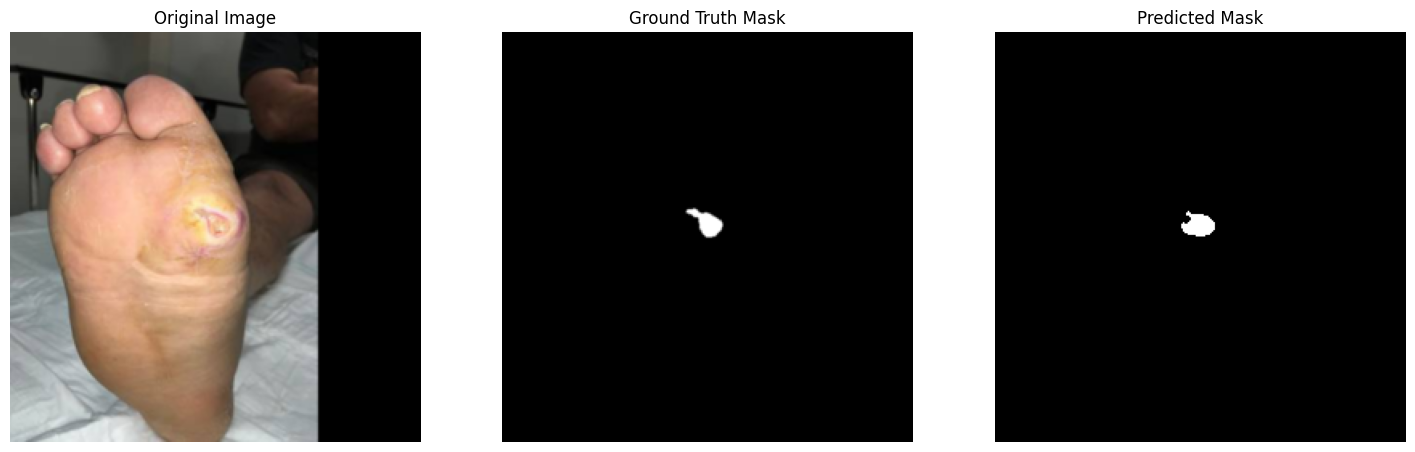

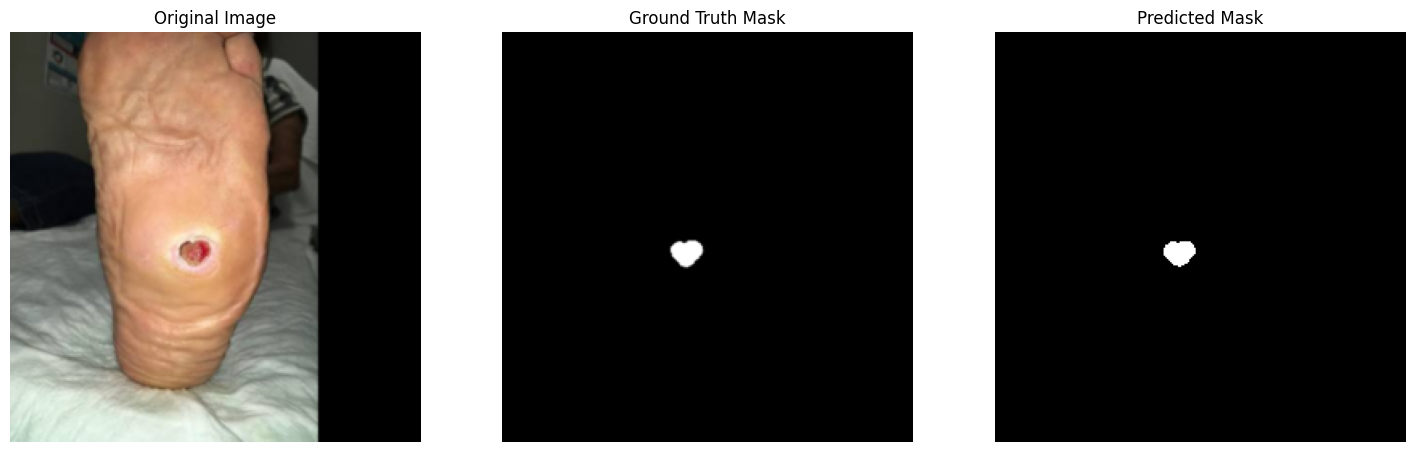

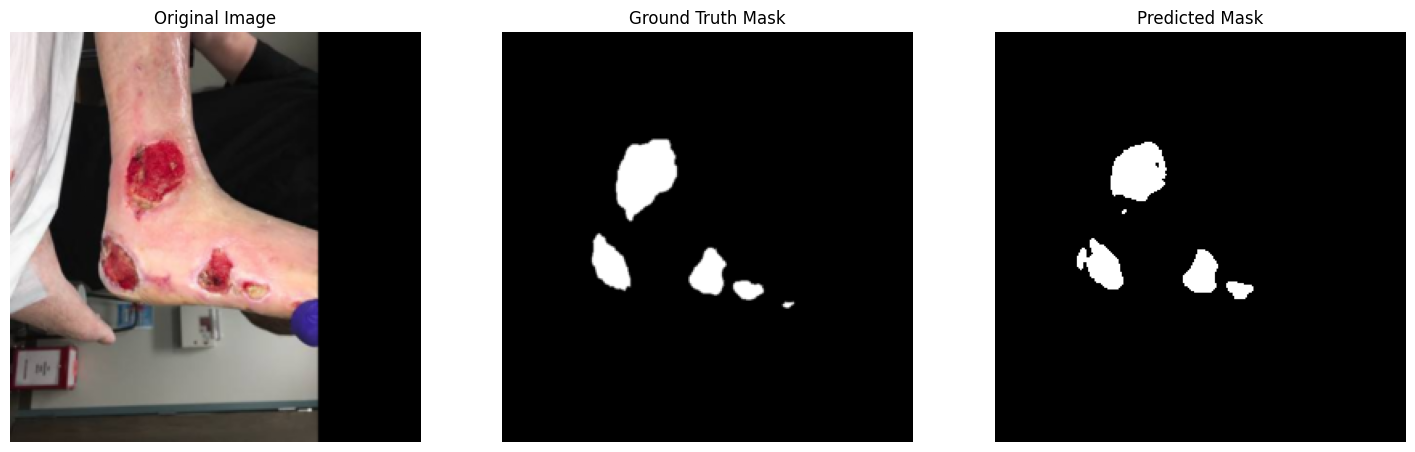

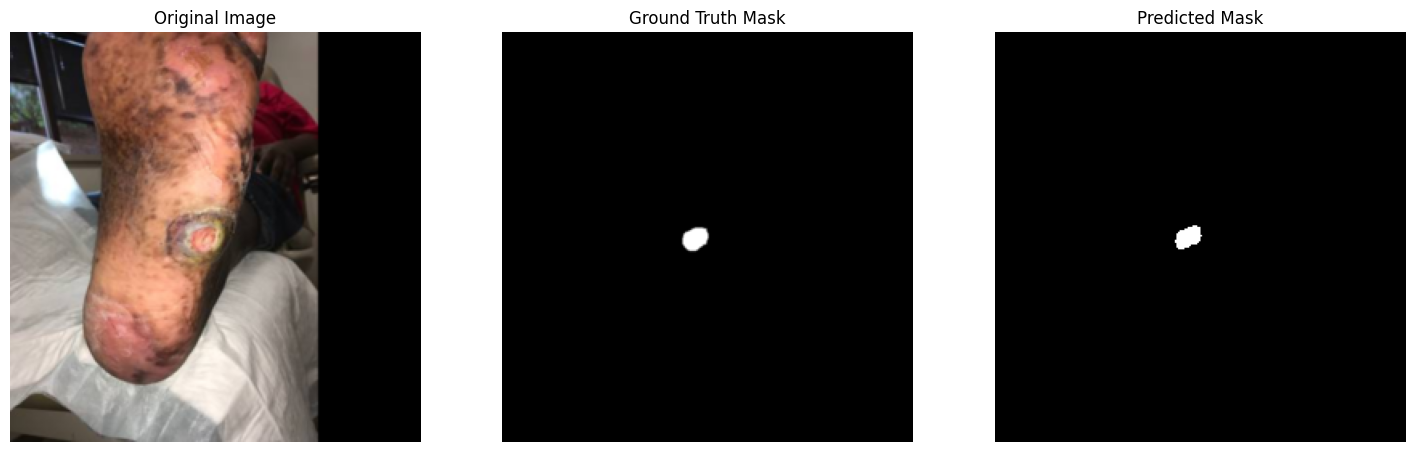

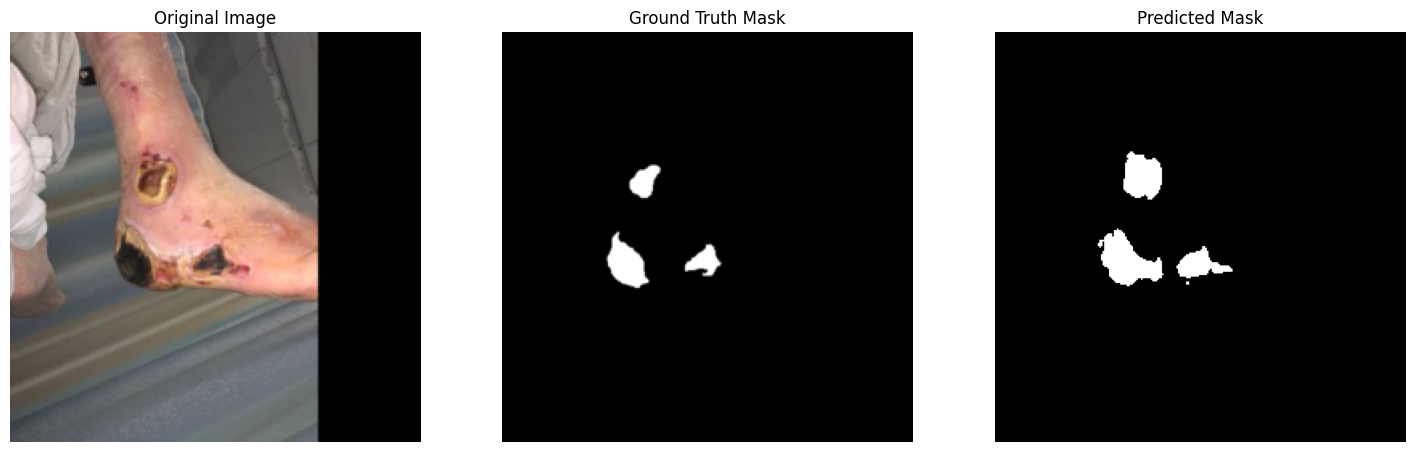

 50%|█████     | 20/40 [17:53<18:10, 54.50s/it]

Epoch [21/40], Loss: 0.0267


 52%|█████▎    | 21/40 [18:46<17:10, 54.21s/it]

Epoch [21/40], Validation Loss: 0.2297
Epoch [22/40], Loss: 0.0252


 55%|█████▌    | 22/40 [19:39<16:10, 53.94s/it]

Epoch [22/40], Validation Loss: 0.2382
Epoch [23/40], Loss: 0.0234


 57%|█████▊    | 23/40 [20:33<15:13, 53.71s/it]

Epoch [23/40], Validation Loss: 0.2228
Epoch [24/40], Loss: 0.0215


 60%|██████    | 24/40 [21:26<14:19, 53.70s/it]

Epoch [24/40], Validation Loss: 0.2316
Epoch [25/40], Loss: 0.0210


 62%|██████▎   | 25/40 [22:19<13:23, 53.55s/it]

Epoch [25/40], Validation Loss: 0.1900
Epoch [26/40], Loss: 0.0212


 65%|██████▌   | 26/40 [23:13<12:29, 53.50s/it]

Epoch [26/40], Validation Loss: 0.1865
Epoch [27/40], Loss: 0.0195


 68%|██████▊   | 27/40 [24:06<11:34, 53.44s/it]

Epoch [27/40], Validation Loss: 0.1650
Epoch [28/40], Loss: 0.0198


 70%|███████   | 28/40 [24:59<10:40, 53.40s/it]

Epoch [28/40], Validation Loss: 0.1830
Epoch [29/40], Loss: 0.0201


 72%|███████▎  | 29/40 [25:53<09:47, 53.37s/it]

Epoch [29/40], Validation Loss: 0.1919
Epoch [30/40], Loss: 0.0185
Epoch [30/40], Validation Loss: 0.1875
Epoch [30/40], Loss: 0.1114


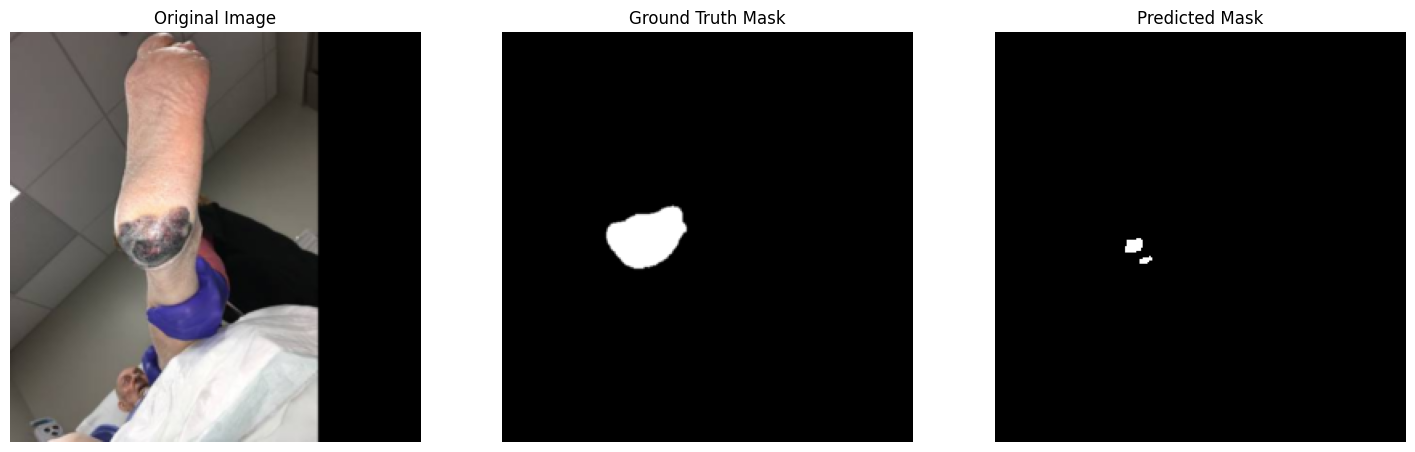

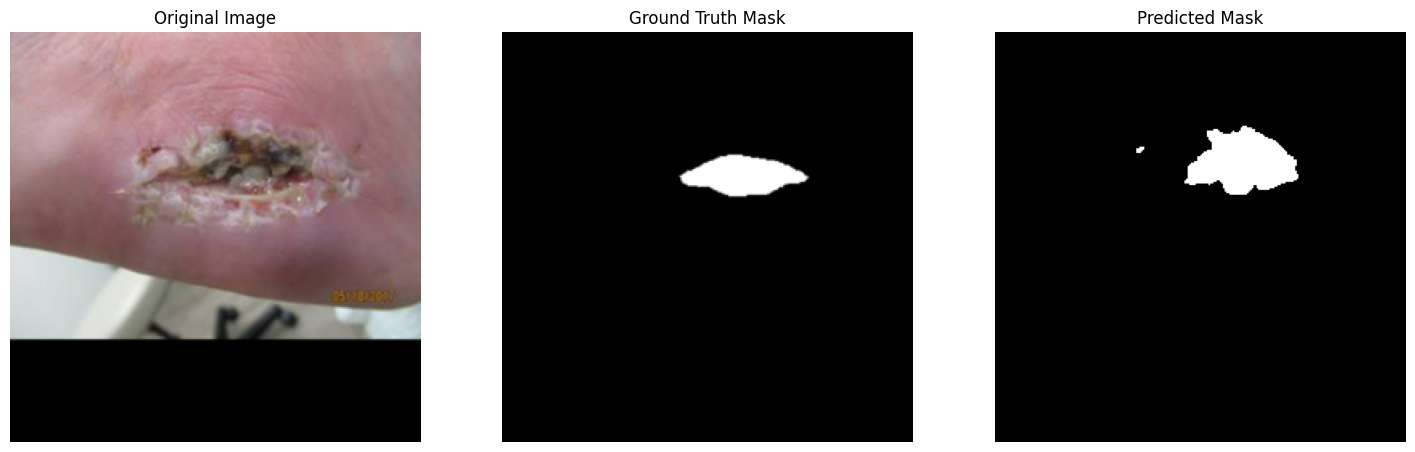

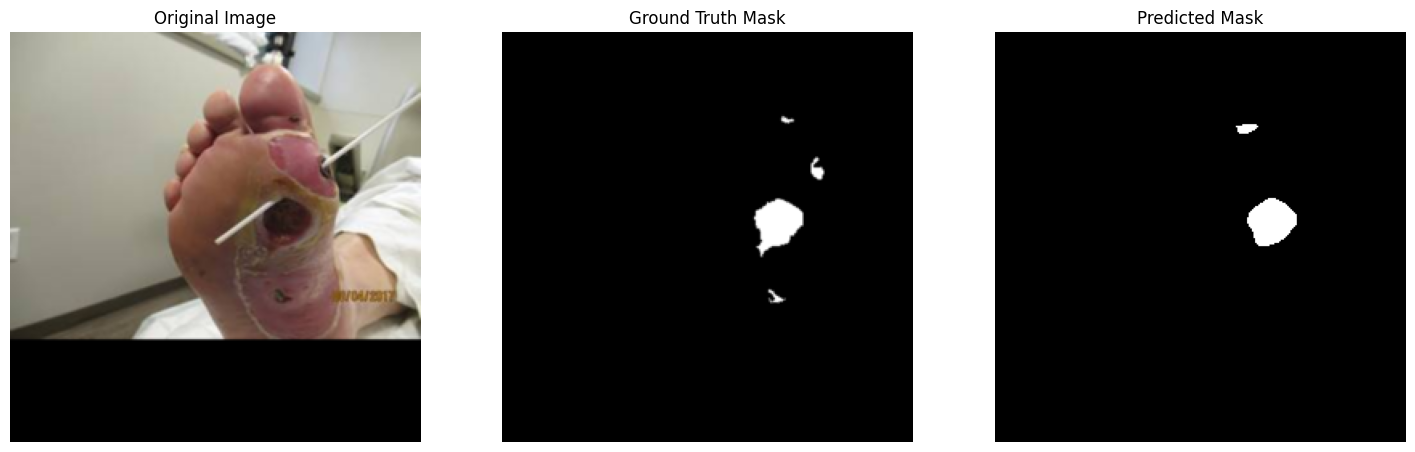

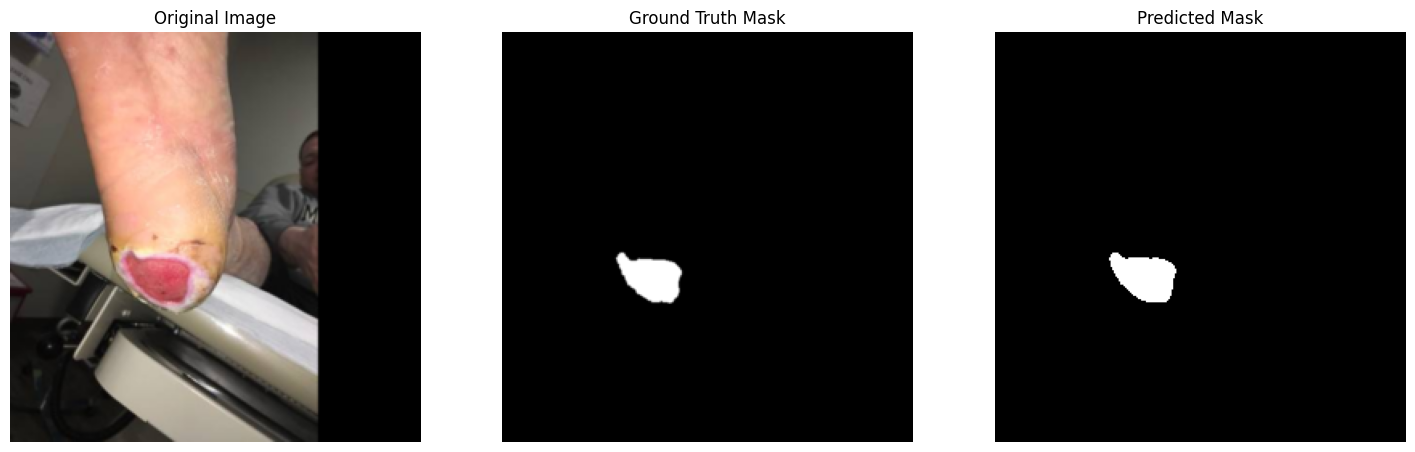

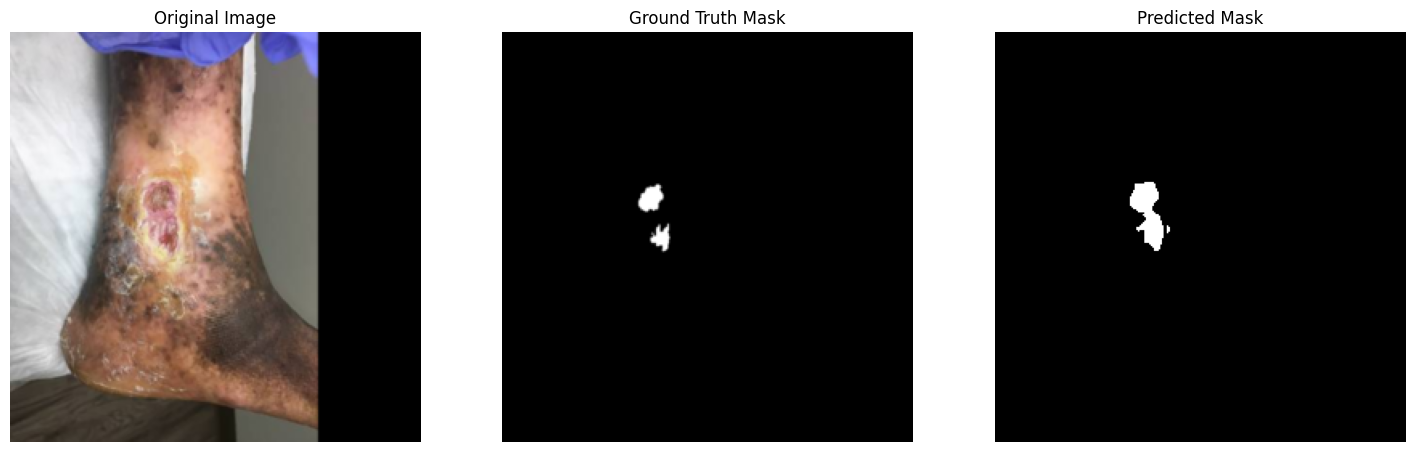

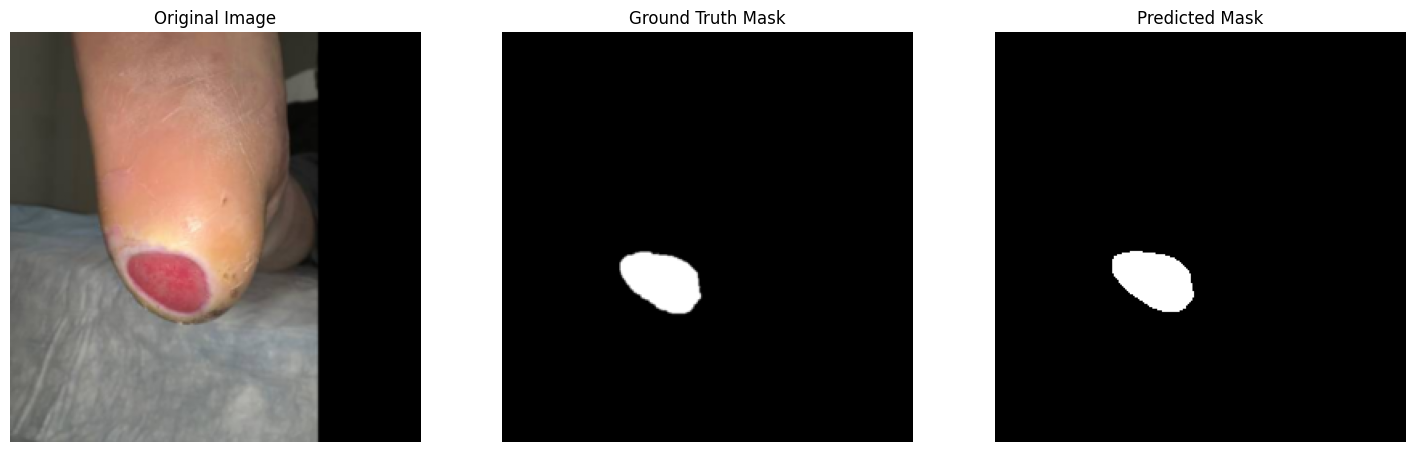

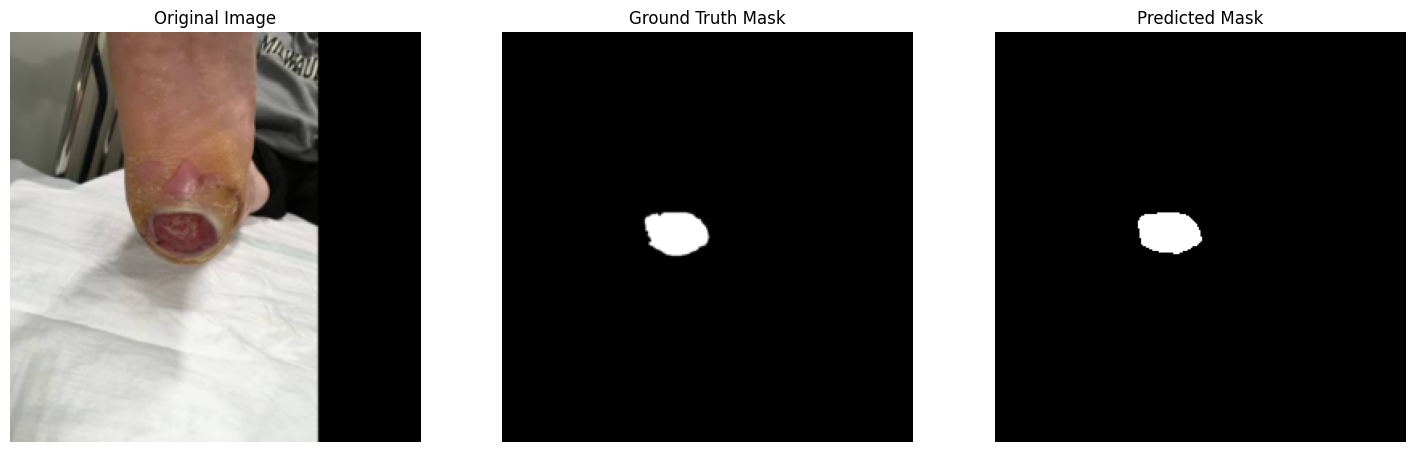

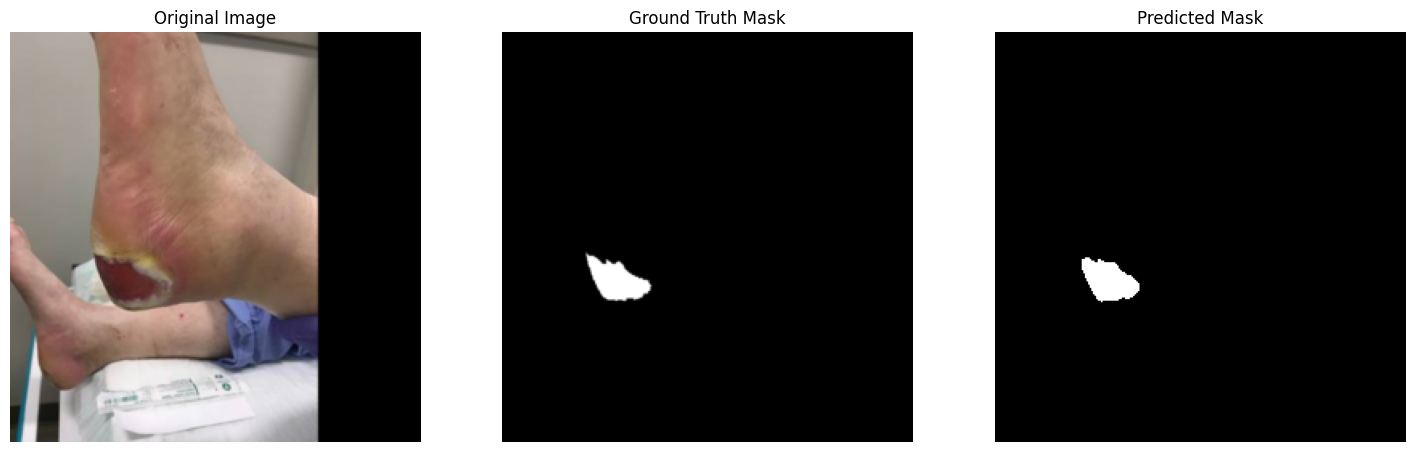

 75%|███████▌  | 30/40 [26:50<09:04, 54.48s/it]

Epoch [31/40], Loss: 0.0185


 78%|███████▊  | 31/40 [27:43<08:07, 54.12s/it]

Epoch [31/40], Validation Loss: 0.2039
Epoch [32/40], Loss: 0.0170


 80%|████████  | 32/40 [28:37<07:11, 53.94s/it]

Epoch [32/40], Validation Loss: 0.1466
Epoch [33/40], Loss: 0.0172


 82%|████████▎ | 33/40 [29:30<06:16, 53.74s/it]

Epoch [33/40], Validation Loss: 0.1893
Epoch [34/40], Loss: 0.0168


 85%|████████▌ | 34/40 [30:23<05:22, 53.69s/it]

Epoch [34/40], Validation Loss: 0.1687
Epoch [35/40], Loss: 0.0168


 88%|████████▊ | 35/40 [31:16<04:27, 53.48s/it]

Epoch [35/40], Validation Loss: 0.1891
Epoch [36/40], Loss: 0.0162


 90%|█████████ | 36/40 [32:10<03:33, 53.48s/it]

Epoch [36/40], Validation Loss: 0.1574
Epoch [37/40], Loss: 0.0162


 92%|█████████▎| 37/40 [33:03<02:40, 53.44s/it]

Epoch [37/40], Validation Loss: 0.2090
Epoch [38/40], Loss: 0.0159


 95%|█████████▌| 38/40 [33:57<01:46, 53.41s/it]

Epoch [38/40], Validation Loss: 0.1445
Epoch [39/40], Loss: 0.0147


 98%|█████████▊| 39/40 [34:50<00:53, 53.35s/it]

Epoch [39/40], Validation Loss: 0.1335
Epoch [40/40], Loss: 0.0148
Epoch [40/40], Validation Loss: 0.1608
Epoch [40/40], Loss: 0.2772


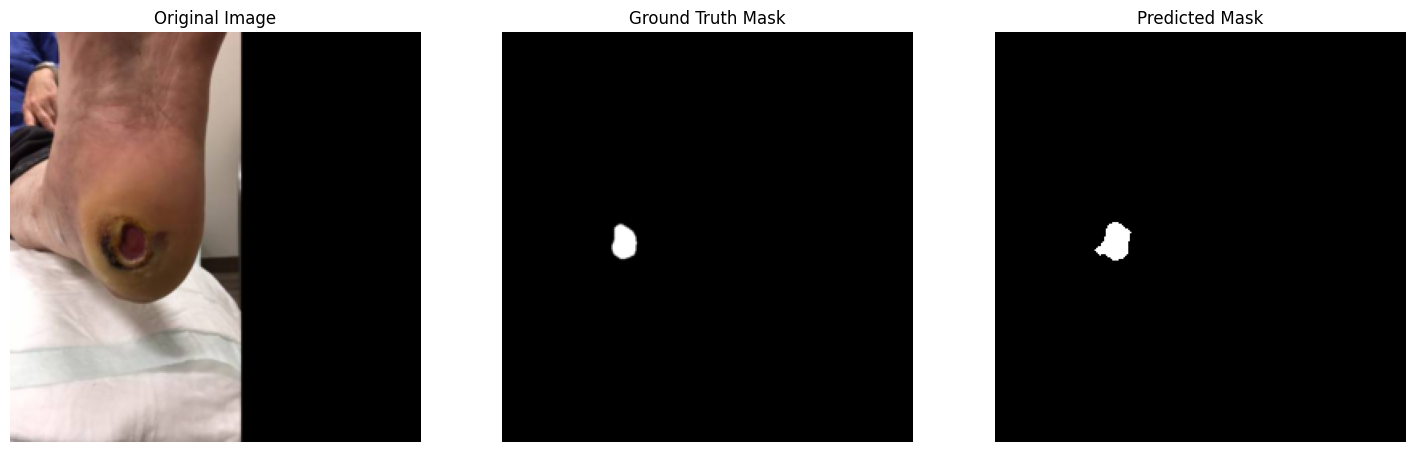

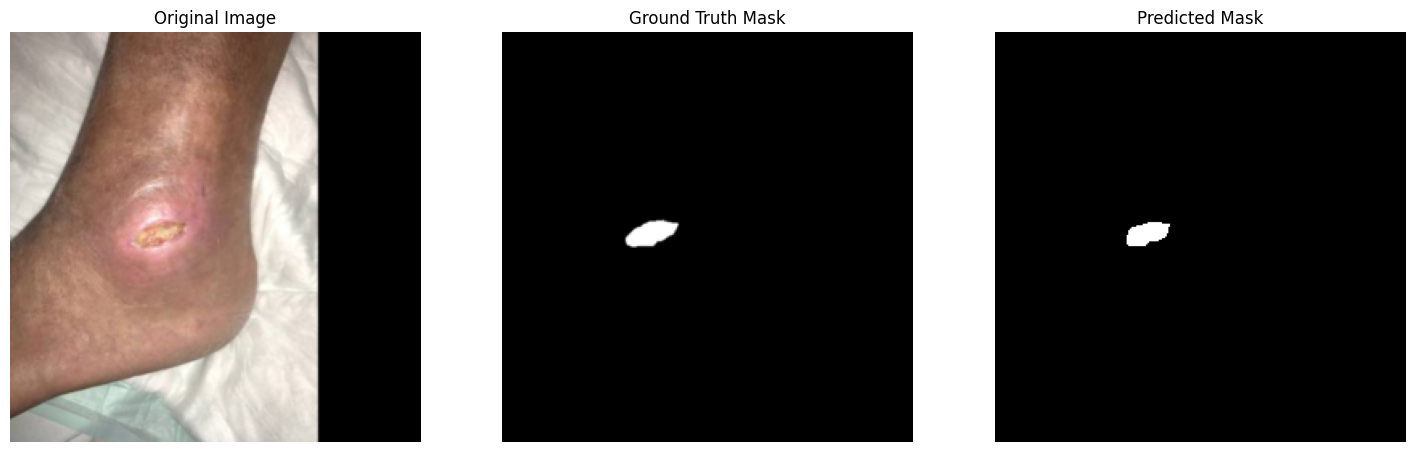

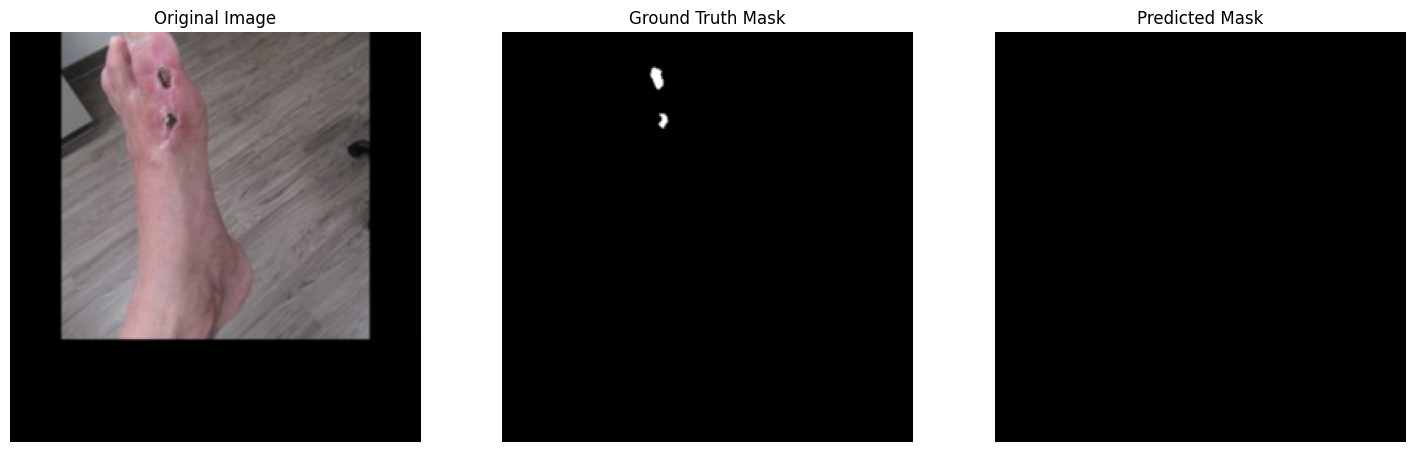

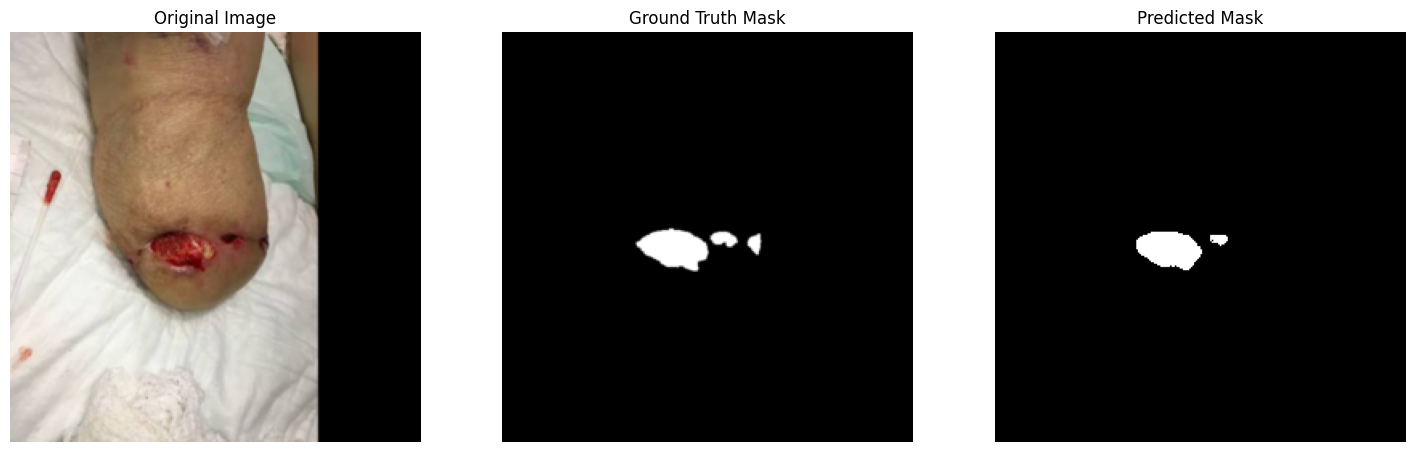

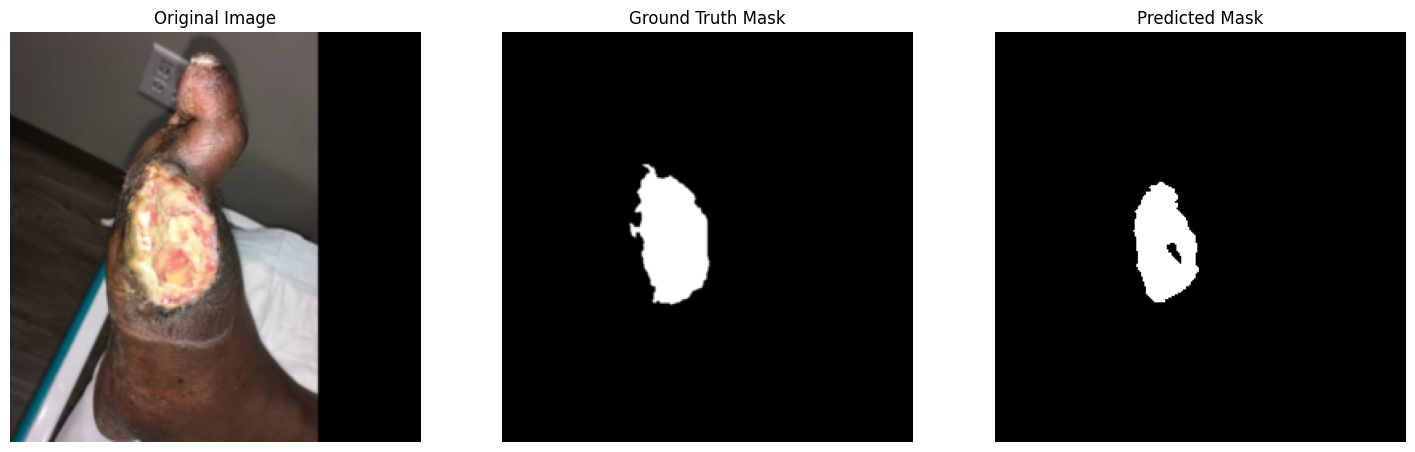

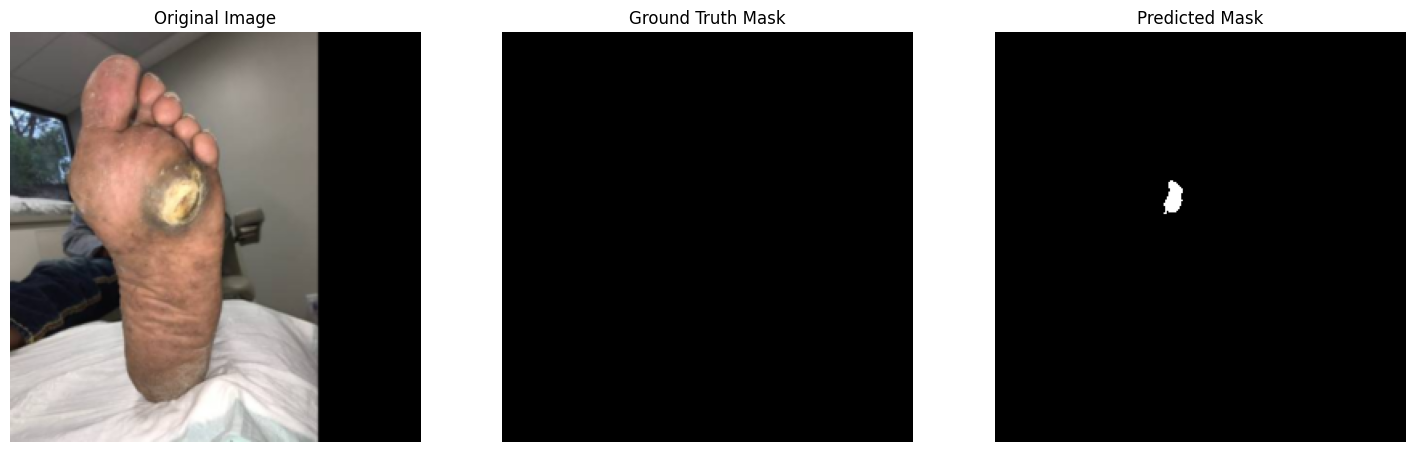

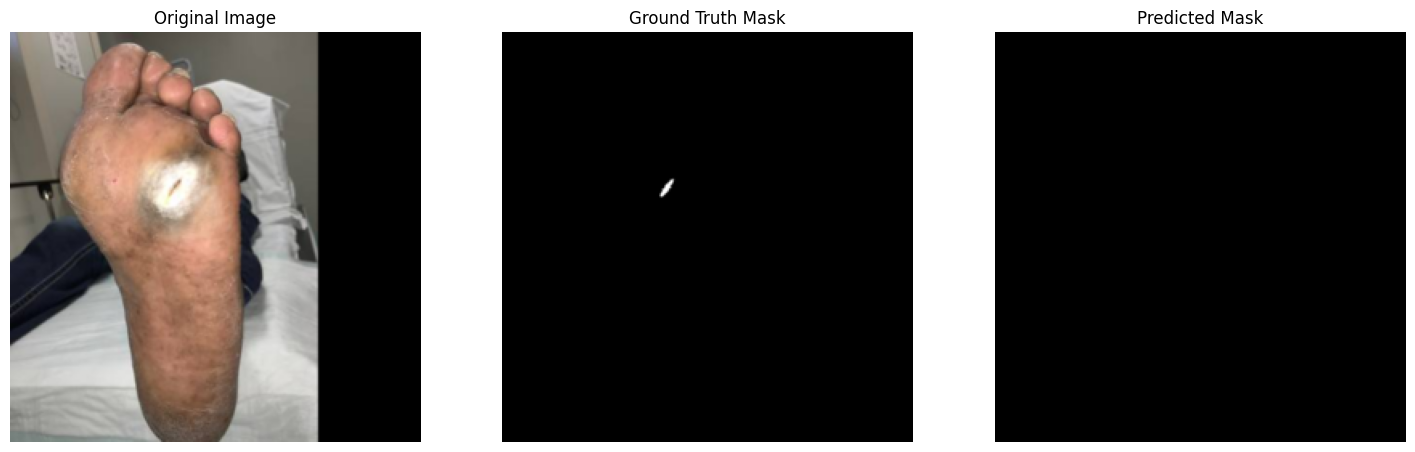

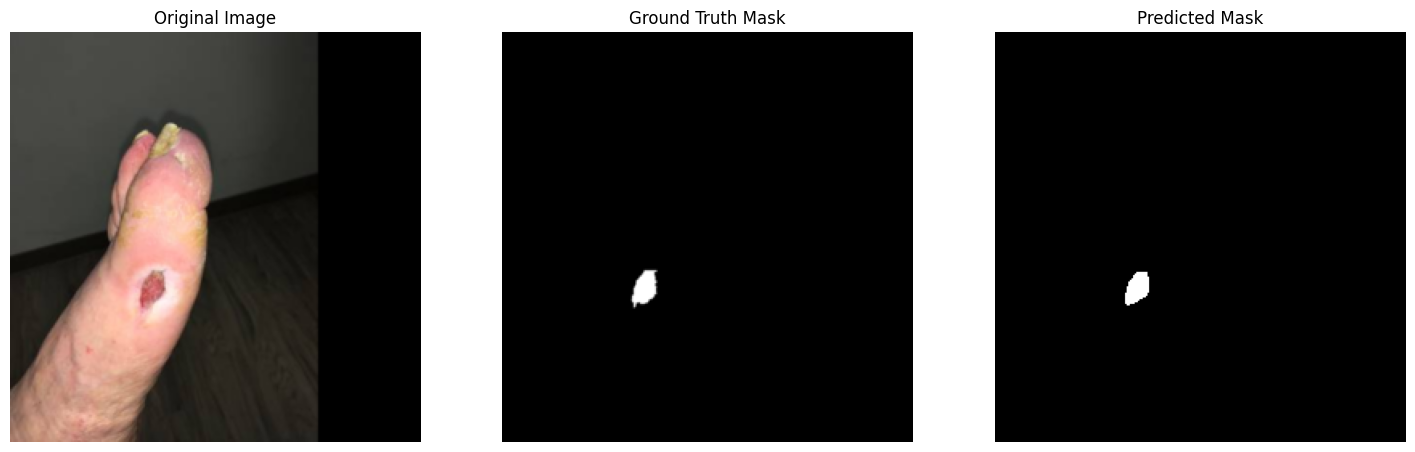

100%|██████████| 40/40 [35:47<00:00, 53.69s/it]


In [15]:
# Initialize model, loss function, and optimizer

#  model = UNet(3,1)

# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs!")
#     model = nn.DataParallel(model)
# else:
#     print("Using single GPU or CPU.")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.apply(init_weights)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for i, images in enumerate(train_loader):
        images, targets = images[0].float().to(device), images[1].float().to(device)

        outputs = model(images)
        optimizer.zero_grad()
        loss = dice_loss(outputs, targets)

        running_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()

    total_running_loss = running_loss / (i+1)
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Evaluation
    model.eval()
    val_loss = 0.0
    intersection = 0
    union = 0
    with torch.no_grad():
        for i, images in enumerate(val_loader):
            images, targets = images[0].float().to(device), images[1].float().to(device)
            outputs = model(images)
            loss = dice_loss(outputs, targets)
            val_loss += loss.item()

            outputs = (outputs > 0.5).float()  # Convert to binary predictions
            intersection += (outputs * targets).sum().item()
            union += (outputs + targets).sum().item() - (outputs * targets).sum().item()

    val_epoch_loss = val_loss / (i+1)
    # iou = intersection / union
    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_epoch_loss:.4f}")

    # Print progress after every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

        # Generate and visualize predicted masks for the validation set

        with torch.no_grad():  # No need to track gradients during inference
            # Get a batch of validation images and masks
            val_inputs, val_targets = next(iter(val_loader))

            # Move data to GPU if available
            if torch.cuda.is_available():
                val_inputs, val_targets = val_inputs.cuda(), val_targets.cuda()

            # Generate predicted masks
            predicted_masks = model(val_inputs)
            predicted_masks = (predicted_masks > 0.5).float().cpu()

        # Visualize the original images, ground truth masks, and predicted masks
        for i in range(len(predicted_masks)):
            image_np = val_inputs[i].permute(1, 2, 0).cpu().numpy()
            ground_truth_mask_np = val_targets[i].squeeze().cpu().numpy()
            predicted_mask_np = predicted_masks[i].squeeze().numpy()

            # Plot original image, ground truth mask, and predicted mask
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))

            axes[0].imshow(image_np)
            axes[0].set_title('Original Image')
            axes[0].axis('off')

            axes[1].imshow(ground_truth_mask_np, cmap='gray')
            axes[1].set_title('Ground Truth Mask')
            axes[1].axis('off')

            axes[2].imshow(predicted_mask_np, cmap='gray')
            axes[2].set_title('Predicted Mask')
            axes[2].axis('off')

            plt.show()
        torch.save(model.state_dict(), "unet_model.pth")

In [ ]:
# class CustomDataset(Dataset):
#     def __init__(self, data, transform=None):
#         self.data = data
#         self.transform = transform

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, index):
#         path = self.data[index]

#         sample = Image.open(path).convert('RGB')

#         if self.transform:
#             sample = self.transform(sample)

#         return sample ,path
# transform = transforms.Compose([
#         transforms.Resize((512, 512)),
#         transforms.ToTensor()
#         ])

# Assuming test_data is your test data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track gradients during inference
    for batch, path in test_loader:
        inputs = batch
        # If you have a GPU available, move the inputs to the GPU
        if torch.cuda.is_available():
            inputs = inputs.cuda()

        predictions = model(inputs)

        # Convert predictions to binary masks (0s and 1s)
        binary_predictions = (predictions > 0.5).float()
        image_np = inputs[0].squeeze().permute(1, 2, 0).cpu().numpy()
        binary_prediction_np = binary_predictions[0].squeeze().cpu().numpy()

        # Load original image using PIL
        original_image = Image.open(path[0]).convert("RGB")
        original_image_np = np.array(original_image.resize((256,256)))

        # Plot original image, ground truth mask, and prediction
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(original_image_np, cmap='gray')
        axes[0].set_title('Original Image')

        axes[1].imshow(binary_prediction_np, cmap='gray')
        axes[1].set_title('Predicted Mask')

        axes[2].imshow(binary_prediction_np, cmap='gray')
        axes[2].imshow(original_image_np, alpha=0.5, cmap='jet')
        axes[2].set_title('Overlay: Original + Predicted Mask')

        for ax in axes:
            ax.axis('off')

        plt.show()


In [ ]:
torch.save(model.state_dict(), "final_model.pth")

In [ ]:
from google.colab import files

files.download('/content/final_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>